In [2]:
# Import Libraries
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Bioinformatics Libraries
import scanpy as sc

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Scapy Settings
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.6 anndata==0.10.3 umap==0.5.5 numpy==1.26.2 scipy==1.11.4 pandas==2.1.4 scikit-learn==1.3.2 statsmodels==0.14.1 igraph==0.11.3 pynndescent==0.5.11


In [3]:
# Load the pbmc3k dataset
sc.datasets.pbmc3k()
adata = sc.read_10x_mtx(
    # the directory with the `.mtx` file
    'data/filtered_gene_bc_matrices/hg19/',
    # use gene symbols for the variable names (variables-axis index)
    var_names='gene_symbols',
    # write a cache file for faster subsequent reading
    cache=True,
)

adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'
adata.write('../write/pbmc3k_raw.h5ad', compression='gzip')
print(adata)

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad
AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'


normalizing counts per cell
    finished (0:00:00)


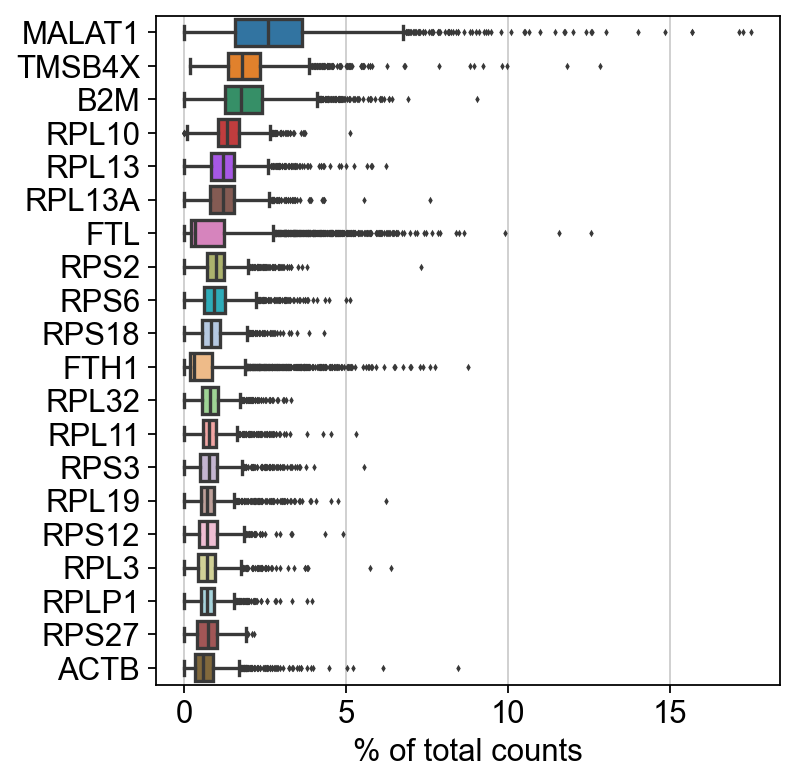

In [4]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20, )

In [5]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)


filtered out 19024 genes that are detected in less than 3 cells


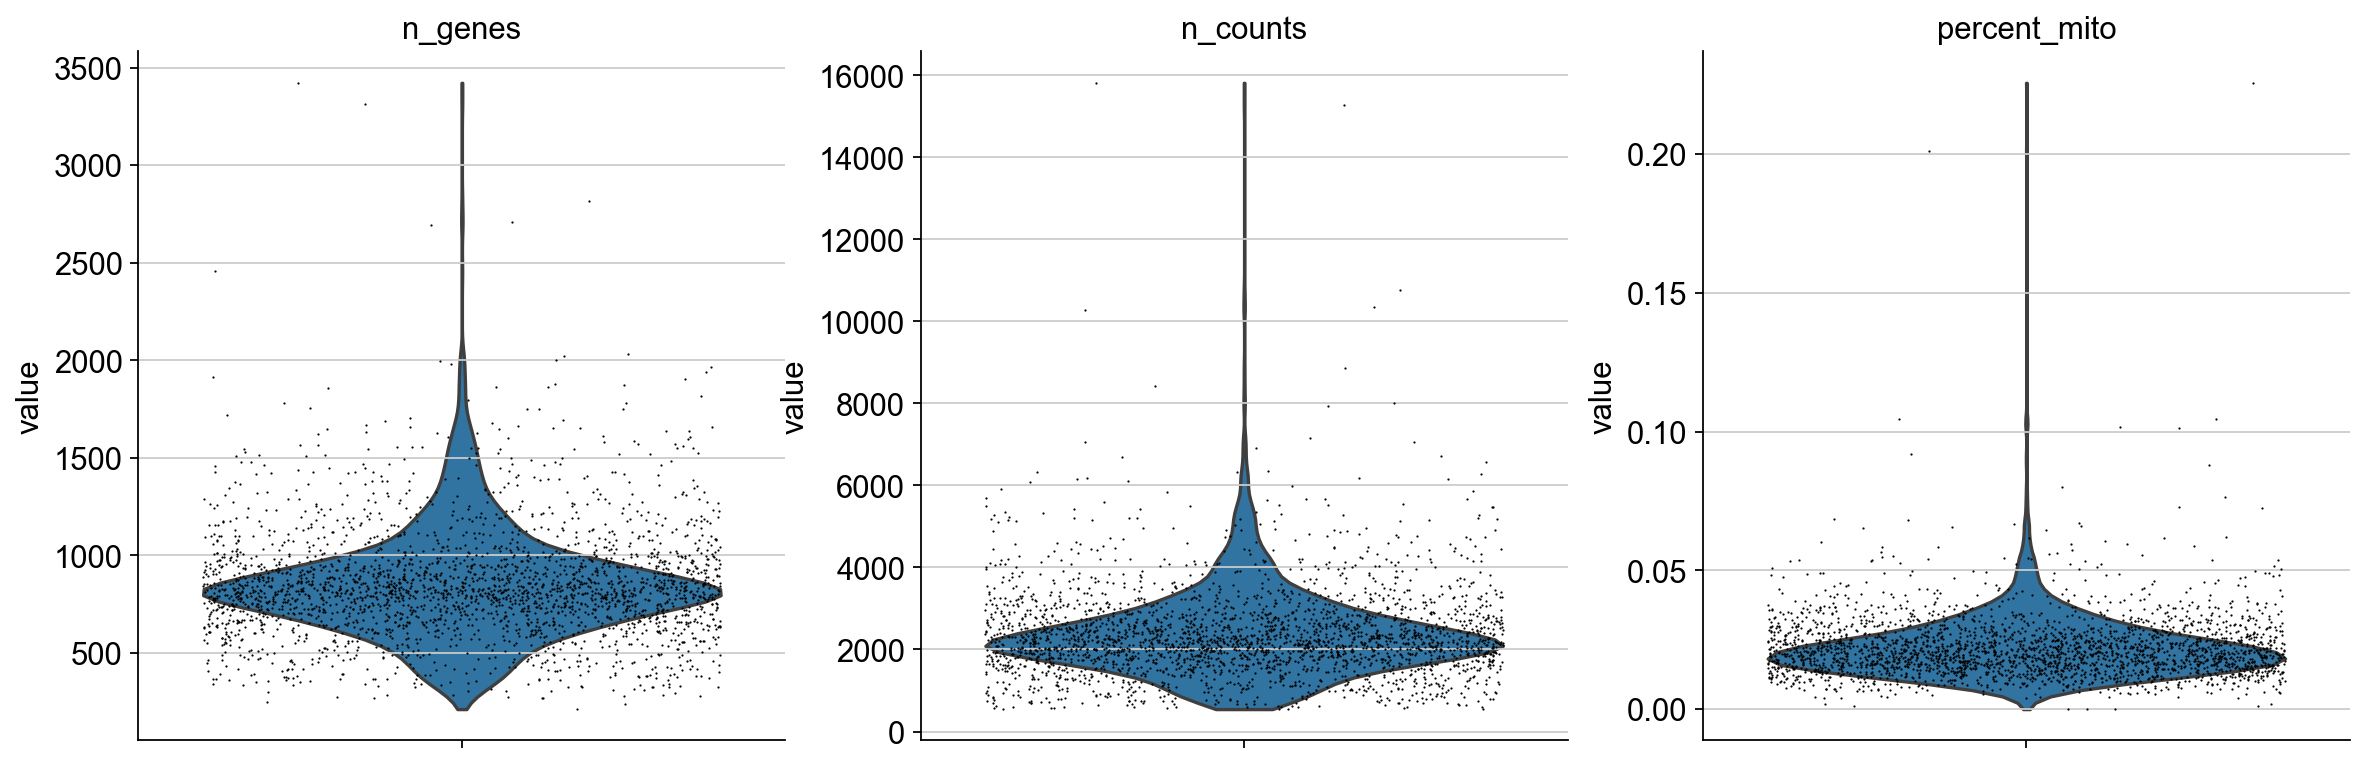

View of AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'


In [6]:
# quality control
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
                jitter=0.4, multi_panel=True)

adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]
print(adata)


In [7]:
# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(adata)

normalizing counts per cell


    finished (0:00:00)


In [8]:
# Store the raw data
adata.raw = adata

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


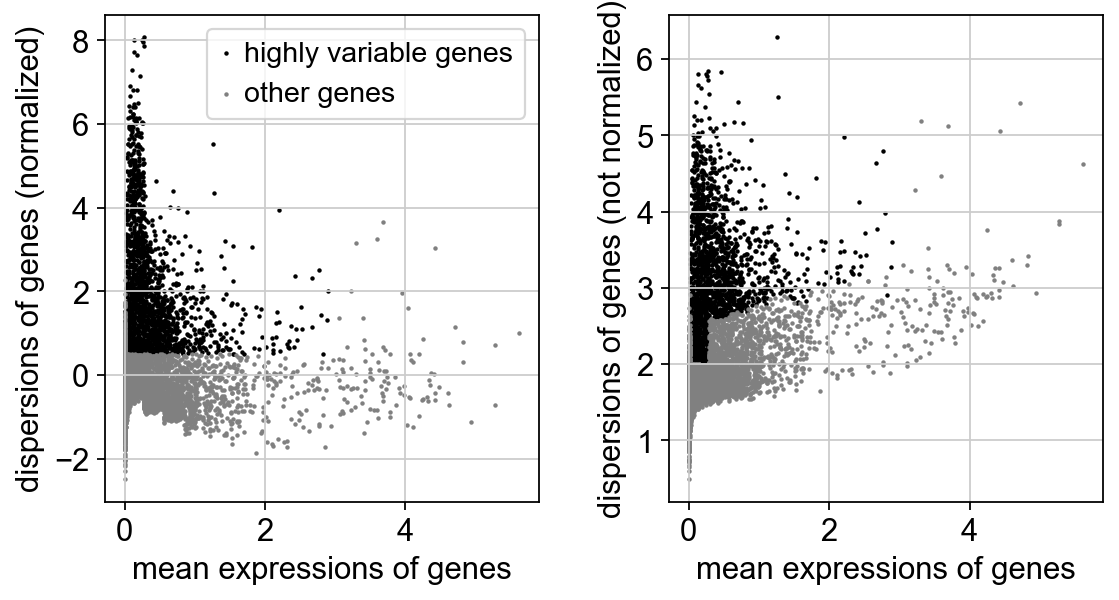

1838


In [9]:
# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# Filter the data
adata = adata[:, adata.var.highly_variable]

# Summarize the highly variable genes
print(adata.var.highly_variable.sum())


In [10]:
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed.
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:02)


In [11]:
# Scale each gene to unit variance. Clip values exceeding standard deviation 10 to remove extreme outliers.
sc.pp.scale(adata, max_value=10)

In [12]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

## Dimension Reduction

### scVAE _ tensorflow

In [13]:
# Import Libraries
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy


In [14]:
# Define the number of input genes
X_counts = adata.raw.X.toarray() if adata.raw is not None else adata.X.toarray()

In [15]:
# Set the dimension of the latent space
latent_dim = 10



# Define the encoder
inputs = Input(shape=(X_counts.shape[1],))
h = Dense(128, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# Define the sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Call the sampling function
z = Lambda(sampling)([z_mean, z_log_var])

# Define the encoder model
encoder = Model(inputs, [z_mean, z_log_var, z])

# Define the decoder
latent_inputs = Input(shape=(latent_dim,))
x = Dense(128, activation='relu')(latent_inputs)
outputs = Dense(X_counts.shape[1], activation='sigmoid')(x)

# Define the decoder model
decoder = Model(latent_inputs, outputs)

# Define the VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs)

# Define the VAE loss
reconstruction_loss = binary_crossentropy(inputs, outputs) * X_counts.shape[1]
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

# Modify the model to add the custom loss
vae.add_loss(vae_loss)




2024-01-02 16:50:06.814007: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-01-02 16:50:06.814046: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-02 16:50:06.814058: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-02 16:50:06.814356: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-02 16:50:06.814635: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
# Compile the model
vae.compile(optimizer='adam')

In [17]:
# Split your data into a training set and a validation set
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(X_counts, test_size=0.1, random_state=42)

# Train the model and record the history, including the validation set
history = vae.fit(X_train, X_train,
                  epochs=200,  # or however many epochs you wish to train for
                  batch_size=256,
                  shuffle=True,
                  verbose=1,
                  validation_data=(X_val, X_val))



Epoch 1/200


2024-01-02 16:50:07.894511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 1s 76ms/step - loss: 6273.1260 - val_loss: 2458.0337
Epoch 2/200
10/10 [==============================] - 0s 26ms/step - loss: 1444.4319 - val_loss: 510.1762
Epoch 3/200
10/10 [==============================] - 0s 27ms/step - loss: -985.3237 - val_loss: -3726.0850
Epoch 4/200
10/10 [==============================] - 0s 31ms/step - loss: -9145.6475 - val_loss: -18808.1484
Epoch 5/200
10/10 [==============================] - 0s 24ms/step - loss: -34183.9922 - val_loss: -58188.3828
Epoch 6/200
10/10 [==============================] - 0s 25ms/step - loss: -92601.5859 - val_loss: -141639.8125
Epoch 7/200
10/10 [==============================] - 0s 24ms/step - loss: -207706.0312 - val_loss: -297488.1250
Epoch 8/200
10/10 [==============================] - 0s 24ms/step - loss: -411105.9062 - val_loss: -565470.5625
Epoch 9/200
10/10 [==============================] - 0s 43ms/step - loss: -757492.0000 - val_loss: -1006781.8125
Epoch 10/200
10/10 [=======

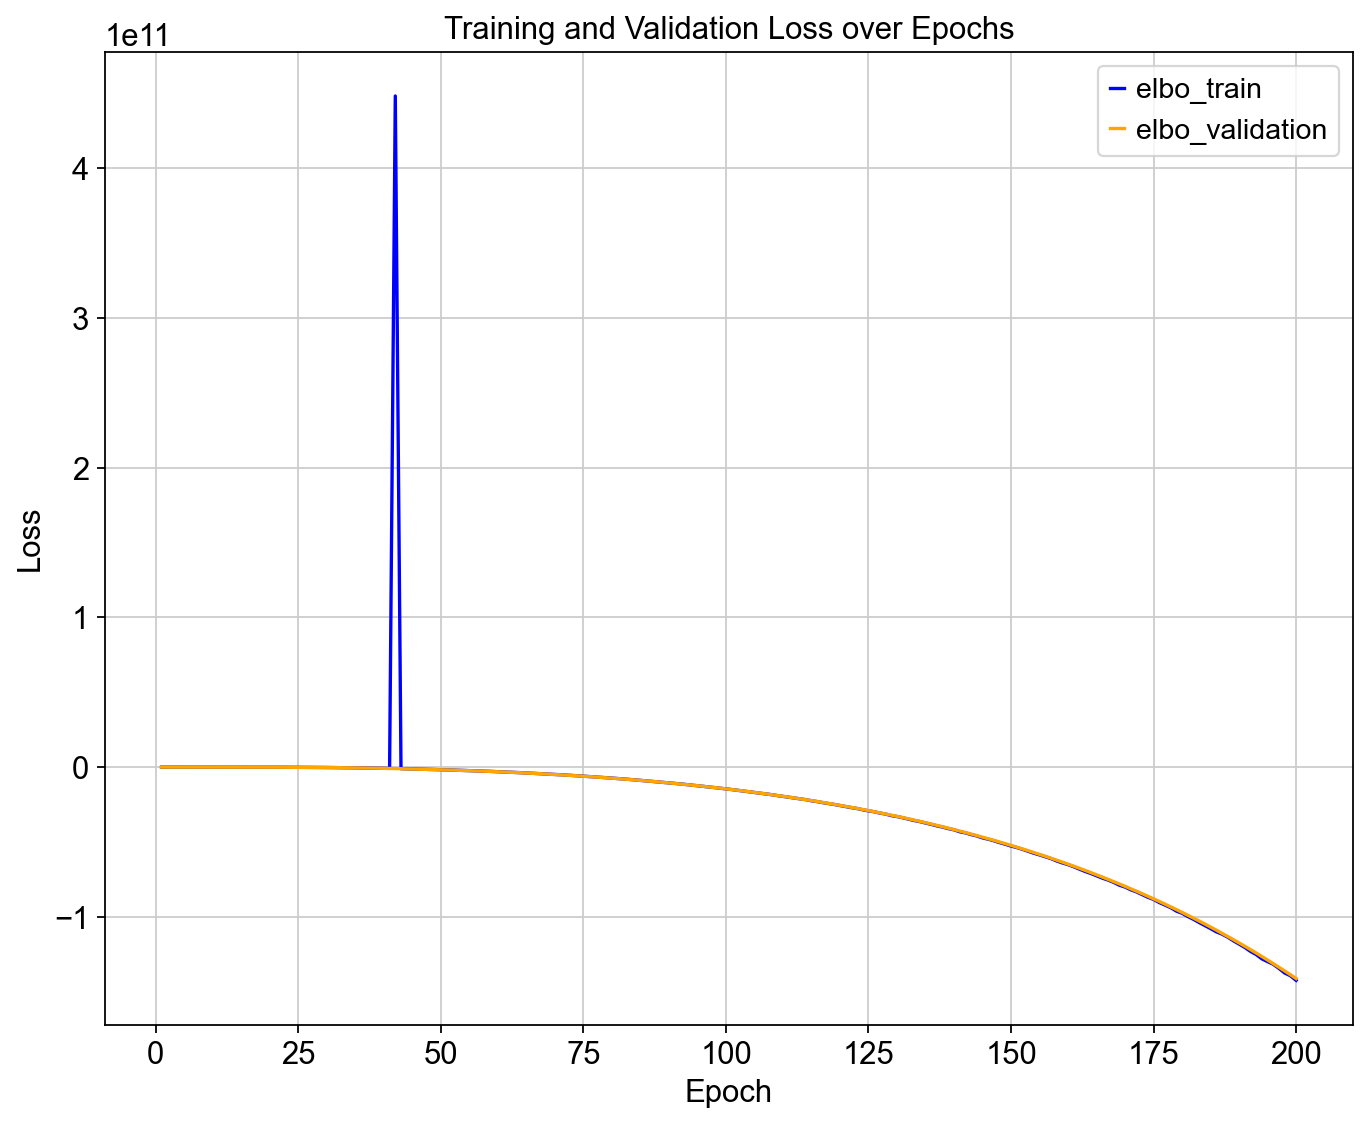

In [18]:
# Extract the training and validation loss
train_loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

# Create the elbow plot
plt.figure(figsize=(10, 8))
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='elbo_train', color='blue')
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label='elbo_validation', color='orange')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
# Extract the Latent Space Representation
z_mean, _, _ = encoder.predict(X_counts, batch_size=256)


11/11 [==============================] - 0s 8ms/step


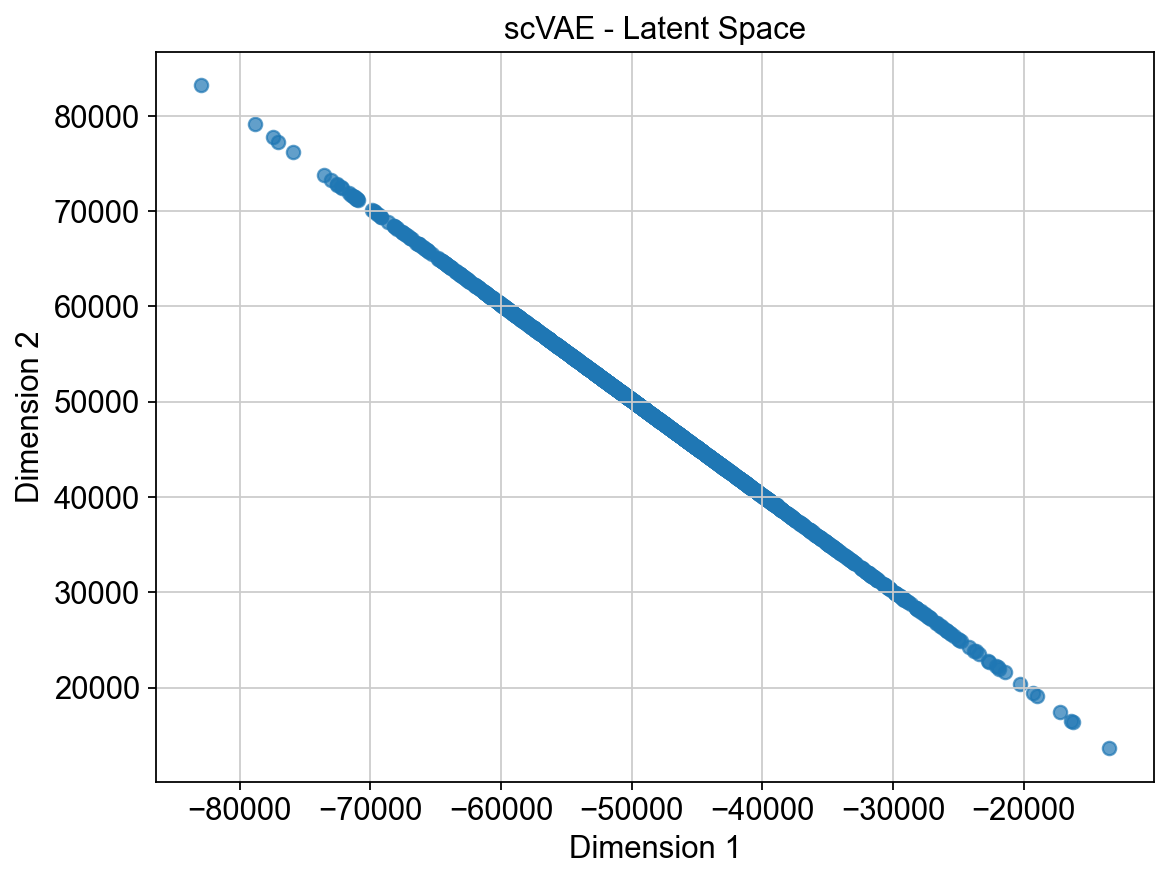

In [20]:
# Visualize the scVAE embedding
plt.figure(figsize=(8, 6))
plt.scatter(z_mean[:, 0], z_mean[:, 1], alpha=0.7)
plt.title('scVAE - Latent Space')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


In [21]:
# Save results
adata.obsm['X_scVAE'] = z_mean


computing PCA
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.`
    on highly variable genes
    with n_comps=10
    finished (0:00:00)


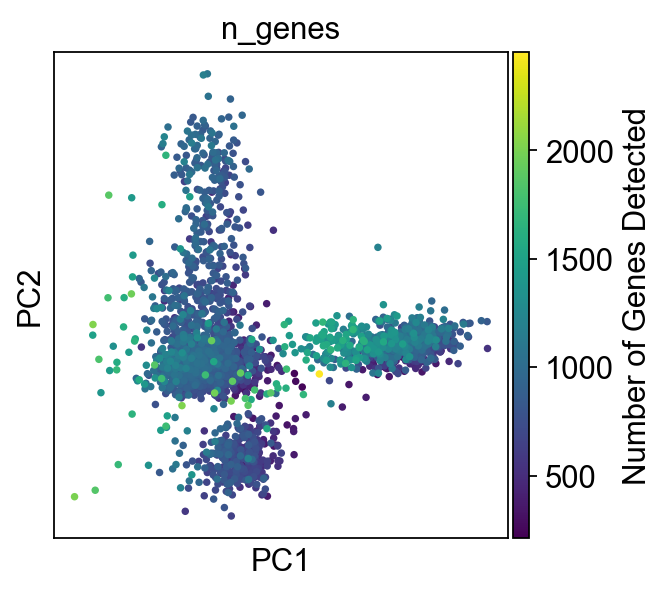

In [25]:
# run pca on the new results
sc.tl.pca(adata, n_comps=10, svd_solver='randomized')

# Visualize the PCA results with coloring by 'n_genes'
sc.pl.pca(adata, color='n_genes', show=False)  # `show=False` to prevent immediate plot display

# Get current axis and figure
ax = plt.gca()
fig = plt.gcf()

# Find the color bar in the current figure
colorbar = ax.collections[0].colorbar

# Set the label for the color bar
colorbar.set_label('Number of Genes Detected')

# Display the plot
plt.show()


In [23]:
adata.write('../write/pbmc3k_scVAE.h5ad', compression='gzip')

In [24]:
# The result is in Z, which we can add back to the AnnData object
scVAE_df = adata.obsm['X_scVAE']

# Convert ZIFA results to DataFrame
scVAE_df = pd.DataFrame(scVAE_df, index=adata.obs_names, columns=[f'scVAE_dim{i+1}' for i in range(10)])

# Save to CSV file
scVAE_df.to_csv('../csv_files/scVAE_results.csv')